### Plant Specimen Image Classification

**Context**

Business context: https://www.kaggle.com/competitions/bttai-nybg-2024/overview \
Data context: https://www.kaggle.com/competitions/bttai-nybg-2024/data

***

**Description**

Help advance biodiversity research by building an ML model to categorize plant specimen images, for the New York Botanical Garden. Using image classification machine learning techniques to train a model capable of distinguishing among the image classes represented in this dataset (i.e., sorting images into classes) with a high level of accuracy.

***

**Problem** 

The New York Botanical Garden's database contains over 40 million images crucial for biodiversity research. However, around 10% of these images are "non-standard," hindering machine learning efforts for species recognition and biodiversity analysis. Due to the lack of adequate description fields, researchers struggle to identify and filter out these non-standard images manually, impending progress in plant science globally.

**Solution**

Develop machine learning models capable of automatically identifying and filtering out non-standard images.

In [41]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import tensorflow as tf
import keras
from tensorflow.keras.applications import ResNet101V2


In [42]:
train_df = pd.read_csv("BTTAIxNYBG-train.csv")
validate_df = pd.read_csv("BTTAIxNYBG-validation.csv")
test_df = pd.read_csv("BTTAIxNYBG-test.csv")

In [43]:
# Load dataset & Define image directory
train_image_directory = 'BTTAIxNYBG-train/BTTAIxNYBG-train/'
validate_image_directory = 'BTTAIxNYBG-validation/BTTAIxNYBG-validation/' 
test_image_directory = 'BTTAIxNYBG-test/BTTAIxNYBG-test/'

### EDA

In [44]:
train_df.head()

,uniqueID,classLabel,classID,source,imageFile
0,2,occluded-specimens,8,L,a1a8b48e8cb142b3.jpg
1,3,microscope-slides,6,L,79599db2ac9092b6.jpg
2,4,illustrations-color,2,BHL,c449696f2f0d0d92.jpg
3,5,illustrations-color,2,P,80a8f4a393b4e08c.jpg
4,6,animal-specimens,0,AK,041a1c6e73313638.jpg


In [45]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81946 entries, 0 to 81945
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   uniqueID    81946 non-null  int64 
 1   classLabel  81946 non-null  object
 2   classID     81946 non-null  int64 
 3   source      81946 non-null  object
 4   imageFile   81946 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.1+ MB


In [46]:
train_df.describe()

,uniqueID,classID
count,81946.000000,81946.000000
mean,61352.780612,4.499597
std,35478.300906,2.872108
min,2.000000,0.000000
25%,30617.250000,2.000000
50%,61169.500000,4.000000
75%,92146.500000,7.000000
max,122879.000000,9.000000


In [47]:
train_df['classLabel'].unique()

array(['occluded-specimens', 'microscope-slides', 'illustrations-color',
       'animal-specimens', 'live-plants', 'biocultural-specimens',
       'illustrations-gray', 'mixed-pressed-specimens',
       'ordinary-pressed-specimens', 'micrographs-transmission-light'],
      dtype=object)

In [48]:
train_df['classLabel'].value_counts() # indicates there isn't class imbalance

classLabel
live-plants                       8200
illustrations-color               8196
illustrations-gray                8196
biocultural-specimens             8195
micrographs-transmission-light    8195
occluded-specimens                8194
animal-specimens                  8194
mixed-pressed-specimens           8193
microscope-slides                 8192
ordinary-pressed-specimens        8191
Name: count, dtype: int64

In [49]:
train_df.isnull().any()

uniqueID      False
classLabel    False
classID       False
source        False
imageFile     False
dtype: bool

### Displaying an Image
#### Sample image from the directory

In [50]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

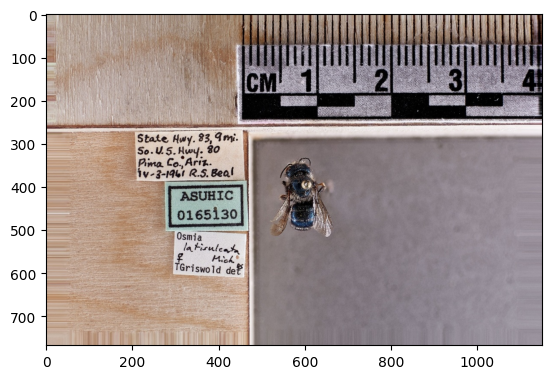

In [51]:
image_path = 'BTTAIxNYBG-train/BTTAIxNYBG-train/0a0a4b6f2f4f4747.jpg'

img = mpimg.imread(image_path)
plt.imshow(img)
plt.show()

### Model Architecture

### Sequential CNN
1. Input Layers: It’s the layer in which we give input to our model. In CNN, Generally, the input will be an image or a sequence of images. This layer holds the raw input of the image with width 32, height 32, and depth 3.

2. Convolutional Layers: This is the layer, which is used to extract the feature from the input dataset. It applies a set of learnable filters known as the filters/kernels (2x2, 3x3, or 5x5 shape) to the input images. It slides over the input image data and computes the dot product between kernel weight and the corresponding input image patch. The output of this layer is referred as feature maps.

3. Activation Layer: By adding an activation function to the output of the preceding layer, activation layers add nonlinearity to the network. it will apply an element-wise activation function to the output of the convolution layer.  Activation functions used : RELU max(0, x).

4. Pooling layer: This layer is periodically inserted in the covnets and its main function is to reduce the size of volume which makes the computation fast reduces memory and also prevents overfitting. Two common types of pooling layers are max pooling and average pooling. If we use a max pool with 2 x 2 filters and stride 2, the resultant volume will be of dimension 16x16x12. 

5. Flattening: The resulting feature maps are flattened into a one-dimensional vector after the convolution and pooling layers so they can be passed into a completely linked layer for categorization.

6. Fully Connected Layers: It takes the input from the previous layer and computes the final classification.

7. Output Layer: The output (vehicle classification) from the fully connected layers is then fed into a logistic function (softmax) for classification tasks which converts the output of each class into the probability score of each class.

![CNN](CNN.png)

### ResNet101V2
1. Characterized by its deep stack of residual blocks
2. Each residual block consists of two 3x3 convolutional layers, surrounded by Batch Normalization and ReLU activation functions.
3. The residual connections ensures the smooth flow of gradients, allowing the network to train efficiently even as it deepens.
4. The architecture is organized into four main blocks, each containing multiple residual blocks. This depth allows ResNet101V2 to learn complex hierarchical features from images, making it highly effective for recognizing patterns in diverse datasets.

![ResNet101V2](image.png)

### Image Preprocessing

In [52]:
# Preprocessing function to load and process images
def train_load_and_preprocess_image(filename, target_size=(224, 224)):
    img_path = os.path.join(train_image_directory, filename)
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Model expects a batch of images
    return img_array / 255.0  # Normalize to [0, 1]

In [53]:
# Preprocessing function to load and process images
def validate_load_and_preprocess_image(filename, target_size=(224, 224)):
    img_path = os.path.join(validate_image_directory, filename)
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Model expects a batch of images
    return img_array / 255.0  # Normalize to [0, 1]


In [54]:
train_df=train_df[:10000]
validate_df=validate_df[:5000]

In [55]:
# Apply preprocessing to all images
train_df['imageData'] = train_df['imageFile'].apply(train_load_and_preprocess_image)

In [56]:
validate_df['imageData'] = validate_df['imageFile'].apply(validate_load_and_preprocess_image)

In [57]:
validate_df.head() # display imageData column

,uniqueID,classLabel,classID,source,imageFile,imageData
0,7,microscope-slides,6,K,f09a8abe9e9e9ef2.jpg,"[[[[0.02745098 0.03137255 0.04705882], [0.0274..."
1,20,illustrations-color,2,BHL,a6c6868387c6af8c.jpg,"[[[[0.78039217 0.67058825 0.5254902 ], [0.7803..."
2,37,ordinary-pressed-specimens,9,YU,6062c68e8c34b292.jpg,"[[[[0.2509804 0.23529412 0.23921569], [0.2666..."
3,59,animal-specimens,0,CAS,363617271597dfd9.jpg,"[[[[0.52156866 0.5019608 0.49019608], [0.5215..."
4,60,biocultural-specimens,1,Met,4218d8d2f42b05e4.jpg,"[[[[0.32156864 0.3137255 0.31764707], [0.3215..."


In [58]:
datagen=ImageDataGenerator(rescale=1./255)

In [59]:
train_generator=datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_image_directory,
    x_col='imageFile',
    y_col='classLabel',
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",  
    target_size=(224, 224)
)

valid_generator=datagen.flow_from_dataframe(
    dataframe=validate_df,
    directory=validate_image_directory,
    x_col='imageFile',
    y_col='classLabel',
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode='categorical',
    target_size=(224, 224)
)


Found 10000 validated image filenames belonging to 10 classes.
Found 5000 validated image filenames belonging to 10 classes.


In [60]:
test_datagen=ImageDataGenerator(rescale=1./255.)

In [61]:
test_generator=test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_image_directory,
    x_col='imageFile',
    batch_size=32,
    seed=42,
    class_mode=None,
    shuffle=False,
    target_size=(224, 224)
)

Found 30690 validated image filenames.


### Early Stopping and Checkpoint

In [62]:
# Early stopping & checkpointing
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

In [63]:
checkpoint = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True)

In [64]:
early_stopper = EarlyStopping(monitor='val_loss', patience=3)

### CNN

In [65]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, RandomRotation
from keras import regularizers, optimizers

In [66]:
# # Sequential CNN
# model = Sequential()
# model.add(Conv2D(32, (3, 3), padding='same', input_shape=(224,224,3)))
# model.add(Activation('relu'))
# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Conv2D(64, (3, 3), padding='same'))
# model.add(Activation('relu'))
# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# model.add(Flatten())
# model.add(Dense(256))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(10, activation='softmax'))
# model.summary()

In [67]:
# import tensorflow.keras.layers as lyrs

### ResNet101V2

In [68]:
# ResNet101V2
model_base = ResNet101V2(input_shape=(224,224,3), include_top=False)
model_base.trainable = True

for layers in model_base.layers[:-30]:
    layers.trainable=False

#Transfer Learning Model
inputs=tf.keras.Input(shape=(224,224,3))
x=model_base(inputs)
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dropout(0.5)(x)
outputs=tf.keras.layers.Dense(10, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(1e-3))(x)


model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet101v2 (Functional)    (None, 7, 7, 2048)        42626560  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout_3 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                20490     
                                                                 
Total params: 42647050 (162.69 MB)
Trainable params: 14464010 (55.18 MB)
Non-trainable params: 28183040 (107.51 MB)
___________

In [69]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [70]:
model_history = model.fit(train_generator, steps_per_epoch=32, epochs=15, validation_data=(valid_generator), callbacks=[checkpoint, early_stopper])

Epoch 1/15
32/32 [==============================] - ETA: 0s - loss: 0.9132 - accuracy: 0.7275
Epoch 00001: val_loss improved from inf to 13.14455, saving model to best_model.h5


/Users/maryhe/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 868s 28s/step - loss: 0.9132 - accuracy: 0.7275 - val_loss: 13.1446 - val_accuracy: 0.4640
Epoch 2/15
32/32 [==============================] - ETA: 0s - loss: 0.4432 - accuracy: 0.8594
Epoch 00002: val_loss improved from 13.14455 to 8.43763, saving model to best_model.h5
32/32 [==============================] - 15717s 507s/step - loss: 0.4432 - accuracy: 0.8594 - val_loss: 8.4376 - val_accuracy: 0.6030
Epoch 3/15
32/32 [==============================] - ETA: 0s - loss: 0.3652 - accuracy: 0.8838  
Epoch 00003: val_loss did not improve from 8.43763
32/32 [==============================] - 19885s 641s/step - loss: 0.3652 - accuracy: 0.8838 - val_loss: 9.2868 - val_accuracy: 0.6206
Epoch 4/15
32/32 [==============================] - ETA: 0s - loss: 0.3349 - accuracy: 0.8896
Epoch 00004: val_loss improved from 8.43763 to 2.06910, saving model to best_model.h5
32/32 [==============================] - 943s 30s/step - loss: 0.3349 - accuracy: 0.8896 - v

### Accuracy Loss Plot

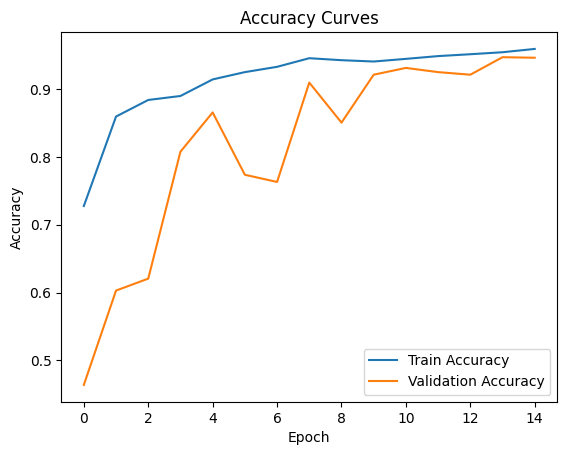

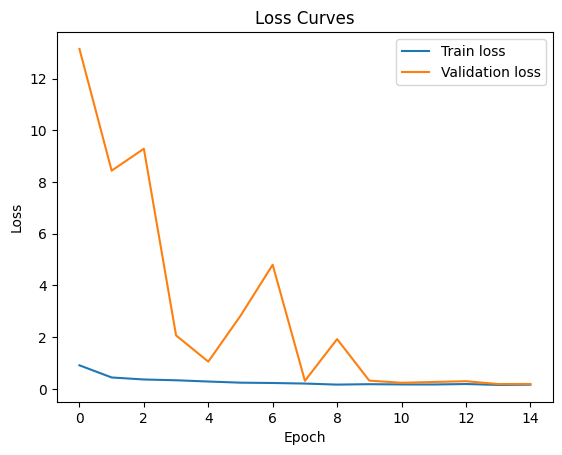

In [71]:
history = model_history.history
val_accuracy = history["val_accuracy"]
val_loss = history["val_loss"]
train_accuracy = history["accuracy"]
train_loss = history["loss"]
    
# Accuracy Plot
plt.plot(train_accuracy, label="Train Accuracy")
plt.plot(val_accuracy, label="Validation Accuracy")
plt.title("Accuracy Curves")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
    
# Loss Plot
plt.plot(train_loss, label="Train loss")
plt.plot(val_loss, label="Validation loss")
plt.title("Loss Curves")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [72]:
loss, accuracy = model.evaluate(valid_generator)
accuracy

157/157 [==============================] - 674s 4s/step - loss: 0.1916 - accuracy: 0.9460


0.9459999799728394

### Predict on Test Data and Output to CSV

In [73]:
prediction = model.predict(test_generator)

960/960 [==============================] - 20767s 22s/step


In [74]:
results = pd.DataFrame({'uniqueID': test_df['uniqueID'], 'classID': prediction.argmax(axis=1)})

In [75]:
results.to_csv('submission.csv', index=False)

### Conclusion

* Finetuned the model by trying different epochs, learning rate, layers, dropouts, optimizer, and loss function. To result in the best performing accuracy score.
* Tested several learning rates: 0.01, 0.001, 0.001. Model performed best at 0.01 with Adam optimizer.
* Found that ResNet101V2 performed better than the sequential CNN with a 94% accuracy score.
* Transfer learning saves time by achieving better performance in fewer epochs.